In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
from tqdm import tqdm_notebook as tqdm 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_results(path = './baseline-runs/task1-bm25/'):
    
    to_read = [f for f in listdir(path) if isfile(join(path, f))]
    all_results = pd.DataFrame()
    
    if 'lucene' in path: sep = ' '
    else: sep = '\t'
    
    for files in to_read:
            
        all_results = all_results.append(pd.read_csv(path + str(files),\
                                  names = ['qid', 'Q0', 'result', 'rank', 'score', 'system'], sep = sep))
        
    if 'lucene' in path:
        
        all_results['result'] = all_results['result'].str.replace('.', '')


    return all_results

      
    
def get_mrr(all_results, query_feedback):
    
    mrr                      = []
    all_results['relevance'] = False

    
    for qid in query_feedback['qid'].unique():
        
        mrr_per_query            = []
        feedback_result          = list(query_feedback.loc[query_feedback['qid'] == qid]['result'])
       
        
        for result in feedback_result:
            
            result_index = all_results.loc[(all_results['qid'] == qid) \
                                           & (all_results['result'] == result)].index.tolist()
            
            all_results.loc[(all_results['qid'] == qid) \
                                           & (all_results['result'] == result), 'relevance'] = True 
            
            if len(result_index) > 0: 
                mrr_per_query.append(result_index[0] + 1)
                
        
        if len(mrr_per_query) != 0: mrr.append(1/min(mrr_per_query))
        else: mrr.append(0)
         
    return np.mean(mrr), all_results

In [19]:
def calc_precision_recall(all_results, query_feedback):
    
    recall = []
    precision = []
    remove_list = set()
    
    all_results = all_results.sort_values(['qid','rank']) 
    
    for qid in tqdm(range(1,len(all_results['qid'].unique()) + 1)):
        
        all_results.loc[(all_results['qid'] == qid), 'relevant_len'] \
                            = len(query_feedback.loc[(query_feedback['qid'] == qid)])
            
        recall_numerator = 0
        
        for index,row in all_results.loc[all_results['qid'] == qid].iterrows():
            
            if qid in list(query_feedback['qid']):
            
                if(row['relevance']): 

                    recall_numerator += 1
                    recall.append(recall_numerator/(row['relevant_len']))
                    precision.append(recall_numerator/row['rank'])


                else: 
                    recall.append(recall_numerator/row['relevant_len'])
                    precision.append(recall_numerator/row['rank'])
                    
                #if qid == 1:
                    
                #    print(recall)
                #    print(precision)
            
            
            else:
                #all_results = all_results.drop(qid, axis = 0)
                recall.append(0)
                precision.append(0)
                remove_list.add(qid)
    


    all_results['recall'] = recall
    all_results['precision'] = precision
    all_results = all_results[~all_results['qid'].isin(remove_list)]
    
    return all_results

In [26]:
def calc_metrics(all_results):
    
    #recall_precision = pd.DataFrame()
    #print(all_results[all_results['relevance']][['precision', 'qid']].groupby('qid'))
    
    
    mean_avg_precision = np.mean(all_results[all_results['relevance']][['precision', 'qid']].groupby('qid').sum() /\
                        all_results[all_results['relevance']][['precision', 'qid']].groupby('qid').count())
    
    recall_precision = all_results.loc[all_results['rank'] == 5][['qid','precision']].set_index('qid')
    recall_precision['precision@20'] = all_results.loc[all_results['rank'] == 20][['qid','precision']].set_index('qid')
    recall_precision.columns = ['precision@5', 'precision@20']
    
    recall_plot_df = pd.DataFrame()
    precision_plot_df = pd.DataFrame()
    precision_recall_plot = pd.DataFrame()

    for qid in all_results['qid'].unique():

        recall_plot_df['qid_' + str(qid)] = all_results.loc[all_results['qid'] == qid, 'recall']

    for qid in all_results['qid'].unique():

        precision_plot_df['qid_' + str(qid)] = all_results.loc[all_results['qid'] == qid, 'precision']


    recall_plot_df['mean'] = recall_plot_df.mean(axis = 1)
    precision_plot_df['mean'] = precision_plot_df.mean(axis = 1)


    precision_recall_plot['mean_precision'] = precision_plot_df['mean']
    precision_recall_plot['mean_recall'] = recall_plot_df['mean']
    
    return mean_avg_precision, recall_precision, precision_recall_plot, all_results

## RESULTS FOR ALL SYSTEMS

In [27]:
all_recall_precision = []

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.431733
dtype: float64
MRR:0.6615012030453206
      precision@5  precision@20
qid                            
1.0           0.0          0.10
2.0           0.6          0.15
3.0           0.0          0.00
4.0           0.2          0.10
5.0           0.2          0.10
6.0           0.4          0.10
7.0           0.6          0.25
8.0           0.2          0.10
9.0           0.4          0.20
10.0          0.6          0.60
11.0          0.6          0.40
12.0          0.4          0.10
13.0          0.6          0.20
14.0          0.2          0.25
15.0          0.2          0.15
16.0          0.2          0.20
17.0          0.6          0.20
18.0          0.0          0.15
19.0          1.0          0.30
20.0          0.4          0.10
21.0          0.0          0.05
22.0          0.4          0.25
23.0          0.6          0.20
24.0          0.2          0.05
25.0          0.8          0.45
26.0          0.2          0.25
27.0          0.8  

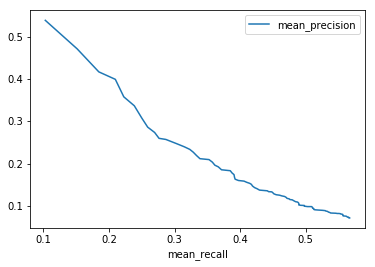

In [28]:
query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task1-bm25/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)

precision_recall_plot.plot(x= 'mean_recall', y='mean_precision')

system_name = 'bm25'
recall_precision.to_csv('./results/precision_' + system_name + '.csv')
all_results.to_csv('./results/results_' + system_name + '.csv')
all_recall_precision.append({system_name : {'x': precision_recall_plot['mean_recall'], 
                             'y': precision_recall_plot['mean_precision']}})


HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.060055
dtype: float64
MRR:0.01884828471676002
      precision@5  precision@20
qid                            
1.0           0.0          0.00
2.0           0.0          0.00
3.0           0.0          0.00
4.0           0.0          0.00
5.0           0.0          0.00
6.0           0.0          0.00
7.0           0.0          0.00
8.0           0.0          0.00
9.0           0.0          0.00
10.0          0.0          0.00
11.0          0.0          0.00
12.0          0.0          0.00
13.0          0.0          0.00
14.0          0.2          0.10
15.0          0.0          0.00
16.0          0.0          0.00
17.0          0.0          0.00
18.0          0.0          0.00
19.0          0.0          0.05
20.0          0.0          0.00
21.0          0.0          0.00
22.0          0.0          0.00
23.0          0.0          0.00
24.0          0.0          0.05
25.0          0.0          0.00
26.0          0.0          0.05
27.0          0.0 

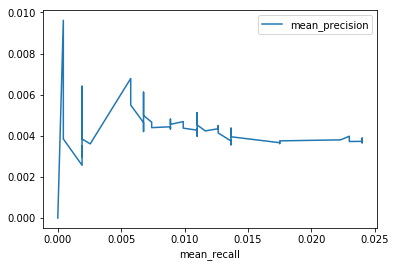

In [29]:
query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task1-jmql/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.sort_values('mean_recall').plot(x= 'mean_recall', y='mean_precision')

system_name = 'jmql'
recall_precision.to_csv('./results/precision_' + system_name + '.csv')
all_results.to_csv('./results/results_' + system_name + '.csv')
all_recall_precision.append({system_name : {'x': precision_recall_plot.sort_values('mean_recall')['mean_recall'], 
                                           'y': precision_recall_plot.sort_values('mean_recall')['mean_precision']}})



HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.246191
dtype: float64
MRR:0.42781569444412615
      precision@5  precision@20
qid                            
1.0           0.0          0.00
2.0           0.2          0.10
3.0           0.0          0.00
4.0           0.2          0.10
5.0           0.2          0.05
6.0           0.0          0.10
7.0           0.2          0.30
8.0           0.0          0.05
9.0           0.2          0.15
10.0          0.0          0.30
11.0          0.6          0.25
12.0          0.4          0.10
13.0          0.4          0.20
14.0          0.6          0.25
15.0          0.2          0.15
16.0          0.0          0.05
17.0          0.2          0.10
18.0          0.0          0.05
19.0          0.0          0.15
20.0          0.0          0.00
21.0          0.2          0.05
22.0          0.8          0.35
23.0          0.4          0.20
24.0          0.2          0.05
25.0          0.4          0.20
26.0          0.0          0.15
27.0          0.2 

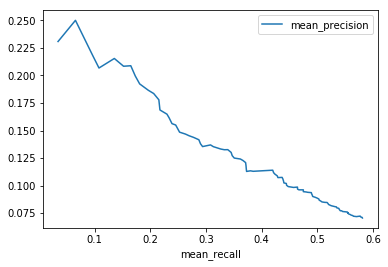

In [30]:
query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task1-tfidf/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.sort_values('mean_recall').plot(x= 'mean_recall', y='mean_precision')

system_name = 'tfidf'
recall_precision.to_csv('./results/precision_' + system_name + '.csv')
all_results.to_csv('./results/results_' + system_name + '.csv')
all_recall_precision.append({system_name : {'x': precision_recall_plot.sort_values('mean_recall')['mean_recall'], 
                                           'y': precision_recall_plot.sort_values('mean_recall')['mean_precision']}})




HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.370832
dtype: float64
MRR:0.6031901650650162
     precision@5  precision@20
qid                           
1            0.0          0.10
2            0.6          0.15
3            0.0          0.05
4            0.2          0.10
5            0.2          0.10
6            0.4          0.10
7            0.6          0.25
8            0.2          0.10
9            0.4          0.15
10           0.4          0.55
11           0.8          0.20
12           0.2          0.10
13           0.2          0.20
14           0.2          0.20
15           0.2          0.15
16           0.2          0.20
17           0.4          0.20
18           0.0          0.10
19           0.2          0.15
20           0.4          0.10
21           0.0          0.05
22           0.4          0.25
23           0.2          0.15
24           0.0          0.05
25           0.2          0.45
26           0.0          0.15
27           0.6          0.20
28           0.8

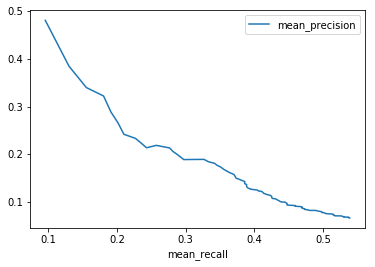

In [31]:
query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task2-bm25-pseudo-relevance/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.plot(x= 'mean_recall', y='mean_precision')

system_name = 'bm25-pseudo-relevance'
recall_precision.to_csv('./results/precision_' + system_name + '.csv')
all_results.to_csv('./results/results_' + system_name + '.csv')
all_recall_precision.append({system_name : {'x': precision_recall_plot.sort_values('mean_recall')['mean_recall'], 
                                           'y': precision_recall_plot.sort_values('mean_recall')['mean_precision']}})




HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.463451
dtype: float64
MRR:0.6646520146520147
     precision@5  precision@20
qid                           
1            0.2          0.10
2            0.6          0.15
3            0.0          0.05
4            0.2          0.10
5            0.4          0.10
6            0.4          0.10
7            0.6          0.25
8            0.2          0.10
9            0.4          0.20
10           0.8          0.55
11           0.6          0.40
12           0.4          0.10
13           0.4          0.20
14           0.0          0.20
15           0.2          0.10
16           0.0          0.20
17           0.4          0.20
18           0.0          0.15
19           0.8          0.30
20           0.4          0.10
21           0.0          0.15
22           0.6          0.40
23           0.6          0.20
24           0.2          0.05
25           0.8          0.45
26           0.2          0.25
27           0.4          0.35
28           0.8

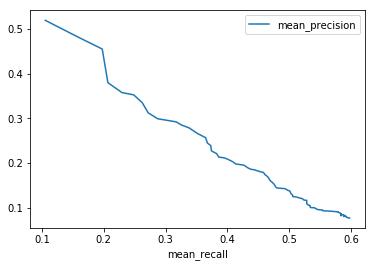

In [32]:

query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task3-bm25-stopping/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.sort_values('mean_recall').plot(x= 'mean_recall', y='mean_precision')

system_name = 'bm25-stopping'
recall_precision.to_csv('./results/precision_' + system_name + '.csv')
all_results.to_csv('./results/results_' + system_name + '.csv')
all_recall_precision.append({system_name : {'x': precision_recall_plot.sort_values('mean_recall')['mean_recall'], 
                                           'y': precision_recall_plot.sort_values('mean_recall')['mean_precision']}})




HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.083253
dtype: float64
MRR:0.06725761848636325
     precision@5  precision@20
qid                           
1            0.0          0.00
2            0.0          0.00
3            0.0          0.00
4            0.0          0.00
5            0.0          0.00
6            0.0          0.00
7            0.0          0.05
8            0.0          0.00
9            0.0          0.00
10           0.0          0.00
11           0.0          0.05
12           0.0          0.00
13           0.0          0.05
14           0.4          0.20
15           0.0          0.05
16           0.0          0.00
17           0.0          0.05
18           0.0          0.05
19           0.0          0.05
20           0.0          0.00
21           0.0          0.00
22           0.0          0.10
23           0.0          0.00
24           0.2          0.05
25           0.0          0.00
26           0.2          0.10
27           0.2          0.10
28           0.

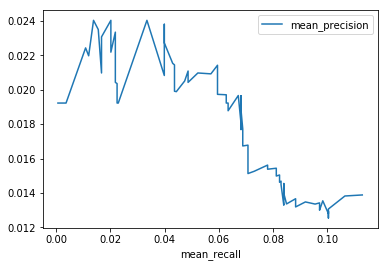

In [33]:

query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task3-JMQL-stopping/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.sort_values('mean_recall').plot(x= 'mean_recall', y='mean_precision')

system_name = 'JMQL-stopping'
recall_precision.to_csv('./results/precision_' + system_name + '.csv')
all_results.to_csv('./results/results_' + system_name + '.csv')
all_recall_precision.append({system_name : {'x': precision_recall_plot.sort_values('mean_recall')['mean_recall'], 
                                           'y': precision_recall_plot.sort_values('mean_recall')['mean_precision']}})



HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.339084
dtype: float64
MRR:0.5408848096348096
     precision@5  precision@20
qid                           
1            0.0          0.05
2            0.6          0.15
3            0.0          0.05
4            0.2          0.15
5            0.2          0.15
6            0.2          0.10
7            0.4          0.40
8            0.2          0.05
9            0.2          0.20
10           0.4          0.50
11           0.8          0.35
12           0.4          0.15
13           0.2          0.25
14           0.4          0.20
15           0.2          0.10
16           0.0          0.00
17           0.0          0.25
18           0.0          0.10
19           0.4          0.30
20           0.0          0.05
21           0.2          0.05
22           0.8          0.40
23           0.8          0.20
24           0.2          0.05
25           0.6          0.15
26           0.0          0.10
27           0.6          0.45
28           0.8

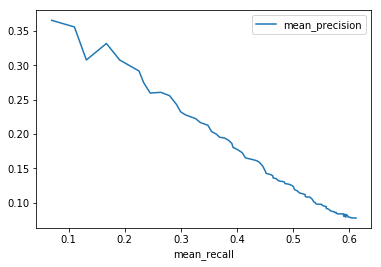

In [34]:

query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task3-TFIDF-stopping/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.sort_values('mean_recall').sort_values('mean_recall').plot(x= 'mean_recall', y='mean_precision')

system_name = 'TFIDF-stopping'
recall_precision.to_csv('./results/precision_' + system_name + '.csv')
all_results.to_csv('./results/results_' + system_name + '.csv')
all_recall_precision.append({system_name : {'x': precision_recall_plot.sort_values('mean_recall')['mean_recall'], 
                                           'y': precision_recall_plot.sort_values('mean_recall')['mean_precision']}})




HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.388641
dtype: float64
MRR:0.65459590173659
     precision@5  precision@20
qid                           
1            0.4          0.10
2            0.6          0.15
3            0.0          0.00
4            0.4          0.10
5            0.4          0.10
6            0.2          0.10
7            0.6          0.35
8            0.4          0.10
9            0.4          0.15
10           0.8          0.60
11           0.6          0.45
12           0.4          0.10
13           0.6          0.20
14           0.0          0.10
15           0.2          0.15
16           0.2          0.10
17           0.4          0.20
18           0.0          0.15
19           0.6          0.30
20           0.6          0.15
21           0.4          0.15
22           0.8          0.65
23           0.6          0.15
24           0.2          0.05
25           0.4          0.35
26           0.0          0.30
27           0.6          0.35
28           0.8  

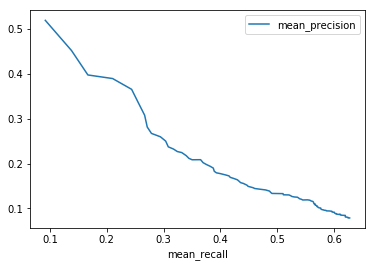

In [35]:

query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task1-lucene_evaluations/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.sort_values('mean_recall').plot(x= 'mean_recall', y='mean_precision')

system_name = 'lucene_evaluations'
recall_precision.to_csv('./results/precision_' + system_name + '.csv')
all_results.to_csv('./results/results_' + system_name + '.csv')
all_recall_precision.append({system_name : {'x': precision_recall_plot.sort_values('mean_recall')['mean_recall'], 
                                           'y': precision_recall_plot.sort_values('mean_recall')['mean_precision']}})





## Plotting all plots

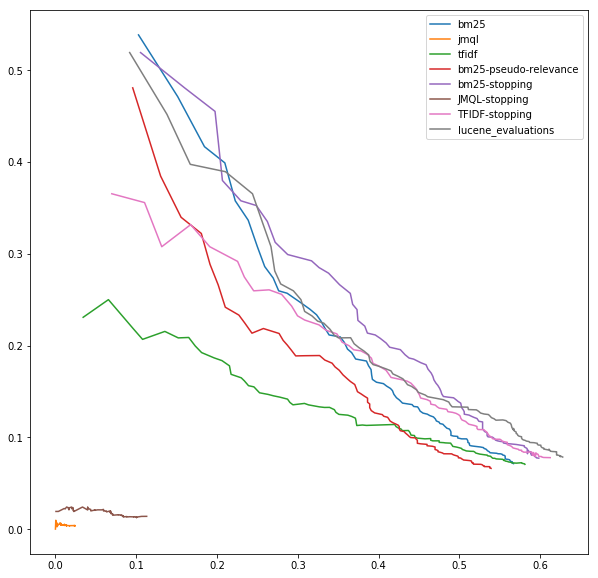

In [36]:
plt.figure(figsize=(10,10))

for system in all_recall_precision:
    
    plt.plot(system[list(system.keys())[0]]['x'], system[list(system.keys())[0]]['y'])
    plt.legend([list(s.keys())[0] for s in all_recall_precision])

plt.savefig('./results/all_results.png', dpi=200)